# FINANCIAL DERIVATIVES 22/23

## Today's date is January 15th 2007 and, to finance an investment project, a company entered into a floating rate loan agreement with the following details:
- Notional: EUR 1,748,653.15
- Start: 19-01-2007
- Maturity: 19-01-2022
- Interest: Euribor 6M, half-yearly, act/360, modified following, adjusted

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from dateutil.relativedelta import *
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'font.size': 20})
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import root

In [2]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [3]:
! pip install latex

## 1. What are the estimated cash flows of this loan on the 15th of January of 2007?

In [3]:
data = pd.read_csv(r'/Users/riccardogurzu/Desktop/FD project/HA_swaps.csv', index_col = 0)
data = data[data.columns[:-2]].dropna() #since there are many NaN values
data

,Deposit 6M,FRA 1X7,FRA 2X8,FRA 3X9,FRA 4X10,FRA 5X11,FRA 6X12,FRA 7X13,FRA 8X14,FRA 9X15,...,Swap 7Y,Swap 8Y,Swap 9Y,Swap 10Y,Swap 11Y,Swap 12Y,Swap 15Y,Swap 20Y,Swap 25Y,Swap 30Y
2007-01-02,3.857,3.9285,3.9770,4.0155,4.0455,4.0755,4.0975,4.0965,4.1010,4.1005,...,4.1175,4.1335,4.1520,4.1720,4.1870,4.2060,4.2445,4.2840,4.2750,4.2590
2007-01-03,3.860,3.9170,3.9720,4.0145,4.0410,4.0670,4.0820,4.0870,4.0920,4.0890,...,4.1155,4.1325,4.1505,4.1715,4.1885,4.2045,4.2580,4.2845,4.2950,4.2635
2007-01-04,3.865,3.9315,3.9865,4.0225,4.0435,4.0720,4.0915,4.0975,4.1025,4.0985,...,4.1110,4.1255,4.1445,4.1625,4.1815,4.1985,4.2455,4.2755,4.2780,4.2565
2007-01-05,3.864,3.9415,3.9950,4.0410,4.0710,4.0950,4.1220,4.1305,4.1365,4.1325,...,4.1525,4.1695,4.1875,4.2055,4.2235,4.2405,4.2885,4.3175,4.3290,4.2970
2007-01-08,3.874,3.9435,4.0015,4.0435,4.0695,4.0985,4.1225,4.1215,4.1275,4.1235,...,4.1485,4.1665,4.1860,4.2060,4.2260,4.2420,4.2885,4.3200,4.3210,4.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,-0.522,-0.5340,-0.5285,-0.5320,-0.5385,-0.5410,-0.5410,-0.5430,-0.5460,-0.5560,...,-0.4250,-0.3835,-0.3405,-0.2965,-0.2550,-0.2130,-0.1180,-0.0425,-0.0395,-0.0675
2020-12-15,-0.520,-0.5225,-0.5320,-0.5315,-0.5360,-0.5375,-0.5380,-0.5400,-0.5430,-0.5500,...,-0.4190,-0.3800,-0.3370,-0.2920,-0.2500,-0.2110,-0.1130,-0.0340,-0.0320,-0.0600
2020-12-16,-0.525,-0.5185,-0.5180,-0.5180,-0.5190,-0.5220,-0.5210,-0.5240,-0.5240,-0.5300,...,-0.3940,-0.3525,-0.3070,-0.2640,-0.2220,-0.1810,-0.0845,-0.0073,-0.0050,-0.0325
2020-12-17,-0.518,-0.5160,-0.5170,-0.5160,-0.5180,-0.5190,-0.5170,-0.5190,-0.5240,-0.5300,...,-0.3960,-0.3550,-0.3110,-0.2660,-0.2235,-0.1820,-0.0820,0.0000,0.0033,-0.0230


In [4]:
class SwapCurve:
    def __init__(self, settlement):
        self.data = data.loc[str(settlement)]
        self.settlement = settlement
        self.curve = pd.DataFrame({
            'inst': self.data.index, 
            'rate': self.data.values/100
            })
        self.generate_dates()
        self.curve.loc[-1, ['inst','maturity']] = ['spot', self.settlement]
        self.curve['days'] = self.curve.maturity.apply(lambda x: (x - self.settlement).days)
        self.curve['maturity'] = pd.to_datetime(self.curve['maturity'])
        self.curve.loc[-1, 'df'] = 1
        self.curve = self.curve.sort_index().reset_index(drop = True)
        self.df()
    
    def getDF(self, dt):
        x = (dt - self.settlement).days
        if x < 0:
            return 0
        return np.interp(x, self.curve.days, self.curve.df)

    def fwd(self, start, end):
        if start < self.settlement:
            return data.loc[:str(start)].iloc[-2]['Deposit 6M']/100
        df0 = self.getDF(start)
        df1 = self.getDF(end)
        dcf = (end - start).days/360
        return (df0/df1 - 1)/dcf

    def generate_dates(self):
        dates = []
        for instrument in self.curve.inst:
            if "6M" in instrument:
                date_instr = self.settlement + relativedelta(months = 6)
                dates.append(date_instr)
            elif "FRA" in instrument:
                x = int(instrument.split("X")[1])
                date_instr = self.settlement + relativedelta(months = x)
                dates.append(date_instr)
            elif "Swap" in instrument:
                y = int(instrument.split(" ")[1].replace("Y",''))
                date_instr = self.settlement + relativedelta(years = y)
                dates.append(date_instr)
        self.curve['maturity'] = dates

    def makeSchedule(self, start, end, freq=6): 
        month_list = [start]
        current = start
        while current < end:
            current += relativedelta(months = freq)
            month_list.append(current)
        return month_list
    
    def df(self):
        for self.idx, self.row in self.curve.iterrows():
            if "Deposit 6M" in self.row.inst:
                dcf = (self.row.maturity.date() - self.settlement).days/360
                self.curve.loc[self.idx, 'df'] = 1/(1 + self.row.rate*dcf)
            if "FRA" in self.row.inst:
                x = self.curve[~self.curve.df.isna()].maturity.apply(datetime.toordinal).values
                y = self.curve[~self.curve.df.isna()].df
                f = interp1d(x, y, kind = 'linear', fill_value = "extrapolate")
                date0 = self.row.maturity + relativedelta(months = -6)
                dcf = (self.row.maturity - date0).days/360
                df0 = f(date0.toordinal())
                df1 = df0/(1 + self.row.rate*dcf)
                self.curve.loc[self.idx, 'df'] = df1
            if "Swap" in self.row.inst:
                prev_dates = self.makeSchedule(self.settlement, self.row.maturity, 12)[1:-1]
                x = self.curve[~self.curve.df.isna()].maturity.apply(datetime.toordinal).values
                y = self.curve[~self.curve.df.isna()].df
                f = interp1d(x, y, kind = 'linear', fill_value = "extrapolate")
                prev_dfs = sum([f(dt.toordinal()) for dt in prev_dates])
                self.curve.loc[self.idx, 'df'] = (1 - self.row.rate*prev_dfs)/(1 + self.row.rate)

In [5]:
start = date(2007, 1, 19)
maturity = date(2022, 1, 19)
today = date(2007, 1, 15)
notional = 1748653.15

In [8]:
crv = SwapCurve(today)
crv.curve

,inst,rate,maturity,days,df
0,spot,NaN,2007-01-15,0,1.000000
1,Deposit 6M,0.038800,2007-07-15,181,0.980865
2,FRA 1X7,0.039520,2007-08-15,212,0.977304
3,FRA 2X8,0.040260,2007-09-15,243,0.973726
4,FRA 3X9,0.040659,2007-10-15,273,0.970428
5,FRA 4X10,0.041048,2007-11-15,304,0.967026
6,FRA 5X11,0.041386,2007-12-15,334,0.963761
7,FRA 6X12,0.041543,2008-01-15,365,0.960472
8,FRA 7X13,0.041606,2008-02-15,396,0.956954
9,FRA 8X14,0.041689,2008-03-15,425,0.953627


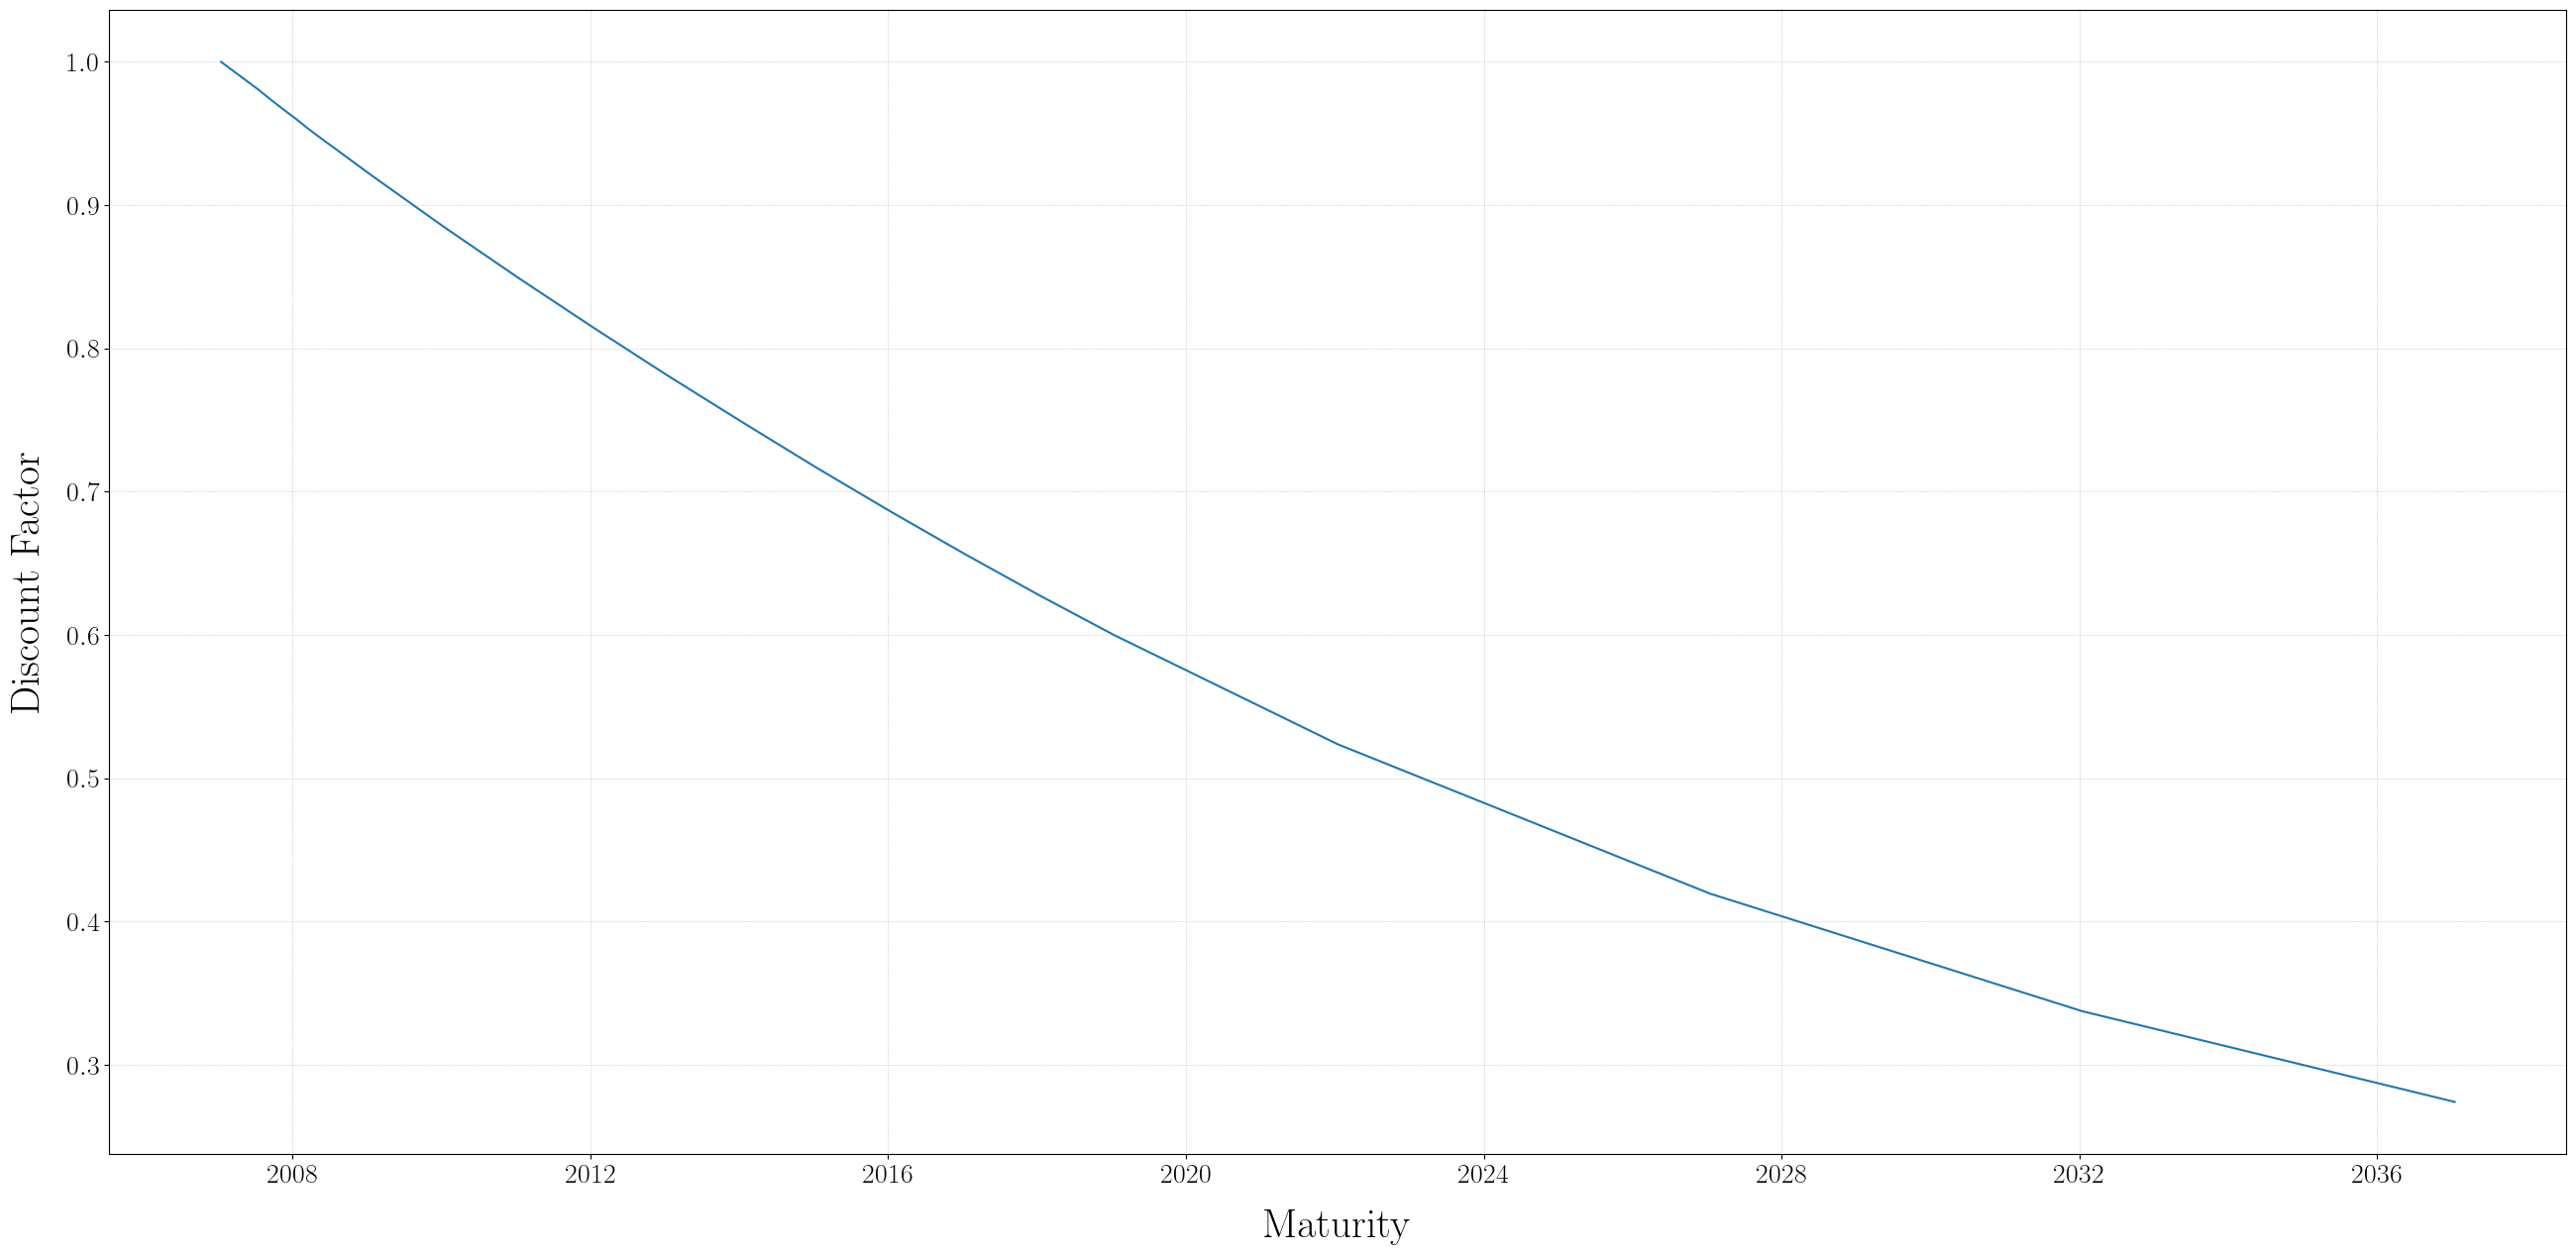

In [15]:
plt.figure(figsize = (32, 15))
plt.plot(crv.curve.maturity, crv.curve.df)
plt.xlabel('Maturity', fontsize = 30, labelpad = 15)
plt.ylabel('Discount Factor', fontsize = 30, labelpad = 15)
plt.grid(linestyle = ':', linewidth = 0.5)

In [6]:
class Leg:
    def __init__(self, notional, start, end, curve, dayCounter, freq):
        self.notional = notional
        self.curve = curve
        self.start = start
        self.end = end
        self.dates = self.MakeSchedule(self.start, self.end, freq)
        leg = pd.DataFrame()
        leg['start'] = self.dates[:-1]
        leg['end'] = self.dates[1:]
        leg['notional'] = notional
        if dayCounter == 'Act/360':    
            leg['dcf'] = leg.apply(lambda x: (x.end - x.start).days/360, axis = 1)
        else:
            leg['dcf'] = 1 if freq == 12 else 0.5
        self.leg = leg
        
    def MakeSchedule(self, start, end, freq=6):
        start = datetime.strptime(self.start, "%Y-%m-%d").date() if isinstance(start, str) else self.start
        end = datetime.strptime(self.end, "%Y-%m-%d").date() if isinstance(end, str) else self.end
        schedule = []
        current_date = start
        while current_date <= end:
            if current_date.weekday() < 5: 
                schedule.append(current_date)
            else:
                next_day = current_date + relativedelta(days = 7 - current_date.weekday())
                if next_day.month == current_date.month:
                    schedule.append(next_day)
                else:
                    prev_day = current_date + relativedelta(days = 4 - current_date.weekday())
                    schedule.append(prev_day)
            current_date += relativedelta(months = freq) 
        return schedule

    def npv(self):
        return (self.leg.cf*self.leg.df).sum()
    
    def format(self):
        return self.leg.style.format({
            'notional': '{:,.2f}', 
            'dcf': '{:,.3f}',
            'rate': '{:.3%}',
            'df': '{:,.4f}',
            'cf': '{:,.2f}'
        })

class FloatingLeg(Leg):
    def __init__(self, notional, start, end, curve, dayCounter = 'Act/360', freq = 6):
        super().__init__(notional, start, end, curve, dayCounter, freq)
        self.leg['rate'] = self.leg.apply(lambda x: curve.fwd(x.start, x.end), axis = 1)
        self.leg['df'] = self.leg.end.apply(curve.getDF)
        self.leg['cf'] = self.leg.notional*self.leg.dcf*self.leg.rate

class FixedLeg(Leg):
    def __init__(self, notional, start, maturity, curve, fixedRate, dayCounter = '30/360', freq = 12):
        super().__init__(notional, start, maturity, curve, dayCounter, freq)
        self.leg['rate'] = fixedRate
        self.leg['df'] = self.leg.end.apply(curve.getDF)
        self.leg['cf'] = self.leg.notional*self.leg.dcf*self.leg.rate

class Swap():
    def __init__(self, notional, start, maturity, crv, fixedRate):
        self.notional = notional
        self.crv = crv
        self.start = start
        self.maturity = maturity
        self.fixedRate = fixedRate
        self.floatingLeg = FloatingLeg(notional, start, maturity, crv)
        self.fixedLeg = FixedLeg(notional, start, maturity, crv, fixedRate)
        
    def npv(self):
        return self.floatingLeg.npv() - self.fixedLeg.npv()

    def updateCurve(self, curve):
        self.fixedLeg = FixedLeg(self.notional, self.start, self.maturity, curve, self.fixedRate)
        self.floatingLeg = FloatingLeg(self.notional, self.start, self.maturity, curve)
    
    def updateFixedRate(self, fixedRate):
        self.fixedRate = fixedRate
        self.fixedLeg = FixedLeg(self.notional, self.start, self.maturity, self.crv, fixedRate)

    def fairRate(self):
        floatLegPV = self.floatingLeg.npv()
        fixedLeg = self.fixedLeg.leg
        return floatLegPV/(fixedLeg.notional*fixedLeg.dcf*fixedLeg.df).sum()

In [9]:
loan = FloatingLeg(notional, start, maturity, crv)
loan.leg.loc[loan.leg.index[-1], "cf"] += notional
loan.format()

,start,end,notional,dcf,rate,df,cf
0,2007-01-19,2007-07-19,"1,748,653.15",0.503,3.889%,0.9804,"34,193.76"
1,2007-07-19,2008-01-21,"1,748,653.15",0.517,4.157%,0.9598,"37,558.80"
2,2008-01-21,2008-07-21,"1,748,653.15",0.506,4.125%,0.9402,"36,470.57"
3,2008-07-21,2009-01-19,"1,748,653.15",0.506,4.090%,0.9211,"36,160.76"
4,2009-01-19,2009-07-20,"1,748,653.15",0.506,4.040%,0.9027,"35,714.16"
5,2009-07-20,2010-01-19,"1,748,653.15",0.508,4.121%,0.8842,"36,631.44"
6,2010-01-19,2010-07-19,"1,748,653.15",0.503,4.044%,0.8666,"35,558.30"
7,2010-07-19,2011-01-19,"1,748,653.15",0.511,4.127%,0.8487,"36,884.82"
8,2011-01-19,2011-07-19,"1,748,653.15",0.503,4.082%,0.8316,"35,884.30"
9,2011-07-19,2012-01-19,"1,748,653.15",0.511,4.166%,0.8142,"37,234.98"


## 2. Consider that company wants to hedge its' interest rate risk with an Interest Rate Swap.

### a. What would be the details of the swap with an annual fixed rate 30/360 in order to have a perfect hedge?

In [10]:
swap = Swap(notional, start, maturity, crv, 0)
fixedRate = swap.fairRate()
swap.updateFixedRate(fixedRate)

In [11]:
print(f"Swap Rate: {fixedRate:.3%}")
display(swap.fixedLeg.format())
display(swap.floatingLeg.format())

Swap Rate: 4.372%


,start,end,notional,dcf,rate,df,cf
0,2007-01-19,2008-01-21,"1,748,653.15",1.000,4.372%,0.9598,"76,456.35"
1,2008-01-21,2009-01-19,"1,748,653.15",1.000,4.372%,0.9211,"76,456.35"
2,2009-01-19,2010-01-19,"1,748,653.15",1.000,4.372%,0.8842,"76,456.35"
3,2010-01-19,2011-01-19,"1,748,653.15",1.000,4.372%,0.8487,"76,456.35"
4,2011-01-19,2012-01-19,"1,748,653.15",1.000,4.372%,0.8142,"76,456.35"
5,2012-01-19,2013-01-21,"1,748,653.15",1.000,4.372%,0.7805,"76,456.35"
6,2013-01-21,2014-01-20,"1,748,653.15",1.000,4.372%,0.7481,"76,456.35"
7,2014-01-20,2015-01-19,"1,748,653.15",1.000,4.372%,0.7164,"76,456.35"
8,2015-01-19,2016-01-19,"1,748,653.15",1.000,4.372%,0.6857,"76,456.35"
9,2016-01-19,2017-01-19,"1,748,653.15",1.000,4.372%,0.6559,"76,456.35"


,start,end,notional,dcf,rate,df,cf
0,2007-01-19,2007-07-19,"1,748,653.15",0.503,3.889%,0.9804,"34,193.76"
1,2007-07-19,2008-01-21,"1,748,653.15",0.517,4.157%,0.9598,"37,558.80"
2,2008-01-21,2008-07-21,"1,748,653.15",0.506,4.125%,0.9402,"36,470.57"
3,2008-07-21,2009-01-19,"1,748,653.15",0.506,4.090%,0.9211,"36,160.76"
4,2009-01-19,2009-07-20,"1,748,653.15",0.506,4.040%,0.9027,"35,714.16"
5,2009-07-20,2010-01-19,"1,748,653.15",0.508,4.121%,0.8842,"36,631.44"
6,2010-01-19,2010-07-19,"1,748,653.15",0.503,4.044%,0.8666,"35,558.30"
7,2010-07-19,2011-01-19,"1,748,653.15",0.511,4.127%,0.8487,"36,884.82"
8,2011-01-19,2011-07-19,"1,748,653.15",0.503,4.082%,0.8316,"35,884.30"
9,2011-07-19,2012-01-19,"1,748,653.15",0.511,4.166%,0.8142,"37,234.98"


### b. What would be the PV01 of the swap?

In [12]:
pv01 = (swap.fixedLeg.notional*swap.fixedLeg.leg.dcf*0.0001*swap.fixedLeg.leg.df).sum()
print(f"Present value of 1 bps on the fixed leg is: EUR {pv01:,.2f}")

Present value of 1 bps on the fixed leg is: EUR 1,903.89


### c. What would be the price of this swap considering that the counterparty charges 5bps from the fair value?

In [13]:
charge = 0.0005
finalRate = charge + fixedRate
print(f"Price Swap charged 5bps: {finalRate:.3%}")

Price Swap charged 5bps: 4.422%


### d. At the trade date, what is the market value of this swap?

In [14]:
#considering that the fixed rate is the 5bps charged rate 
swap.updateFixedRate(finalRate)
print(f"Market Value of 15Y Swap: EUR {swap.npv():,.2f}")
swap.fixedLeg.format()

Market Value of 15Y Swap: EUR -9,519.47


,start,end,notional,dcf,rate,df,cf
0,2007-01-19,2008-01-21,"1,748,653.15",1.000,4.422%,0.9598,"77,330.67"
1,2008-01-21,2009-01-19,"1,748,653.15",1.000,4.422%,0.9211,"77,330.67"
2,2009-01-19,2010-01-19,"1,748,653.15",1.000,4.422%,0.8842,"77,330.67"
3,2010-01-19,2011-01-19,"1,748,653.15",1.000,4.422%,0.8487,"77,330.67"
4,2011-01-19,2012-01-19,"1,748,653.15",1.000,4.422%,0.8142,"77,330.67"
5,2012-01-19,2013-01-21,"1,748,653.15",1.000,4.422%,0.7805,"77,330.67"
6,2013-01-21,2014-01-20,"1,748,653.15",1.000,4.422%,0.7481,"77,330.67"
7,2014-01-20,2015-01-19,"1,748,653.15",1.000,4.422%,0.7164,"77,330.67"
8,2015-01-19,2016-01-19,"1,748,653.15",1.000,4.422%,0.6857,"77,330.67"
9,2016-01-19,2017-01-19,"1,748,653.15",1.000,4.422%,0.6559,"77,330.67"


### e. Consider that today is 18th of December 2020 and calculate the historic daily market value of the swap (from 31.01.2007 to 30.11.2020)

In [15]:
mv = []
rate = []
dates = []
for idx, row in data.loc['2007-01-31':'2020-11-30'].iterrows():
    dt = datetime.strptime(idx, '%Y-%m-%d').date()
    dates.append(dt)
    crv = SwapCurve(dt)
    swap.updateCurve(crv)
    mv.append(swap.npv())
    rate.append(data.loc[idx, 'Swap 15Y'])

pd.DataFrame({'Market Value': mv, r'Swap Rate %': rate}, index = dates)

,Market Value,Swap Rate %
2007-01-31,-167.435665,4.4278
2007-02-01,-2330.406083,4.4170
2007-02-02,-7265.505961,4.3930
2007-02-05,-12080.425623,4.3660
2007-02-06,-16329.113499,4.3455
...,...,...
2020-11-24,-167440.021415,-0.0380
2020-11-25,-167390.448161,-0.0450
2020-11-26,-167455.895307,-0.0620
2020-11-27,-167473.360739,-0.0680


### f. Make a plot of the Market Value of this swap and the market rate of the 15y swap (market value in Euros on the left axis and swap rate in % in the right axis). Comment on the reason(s) for lines to diverge.

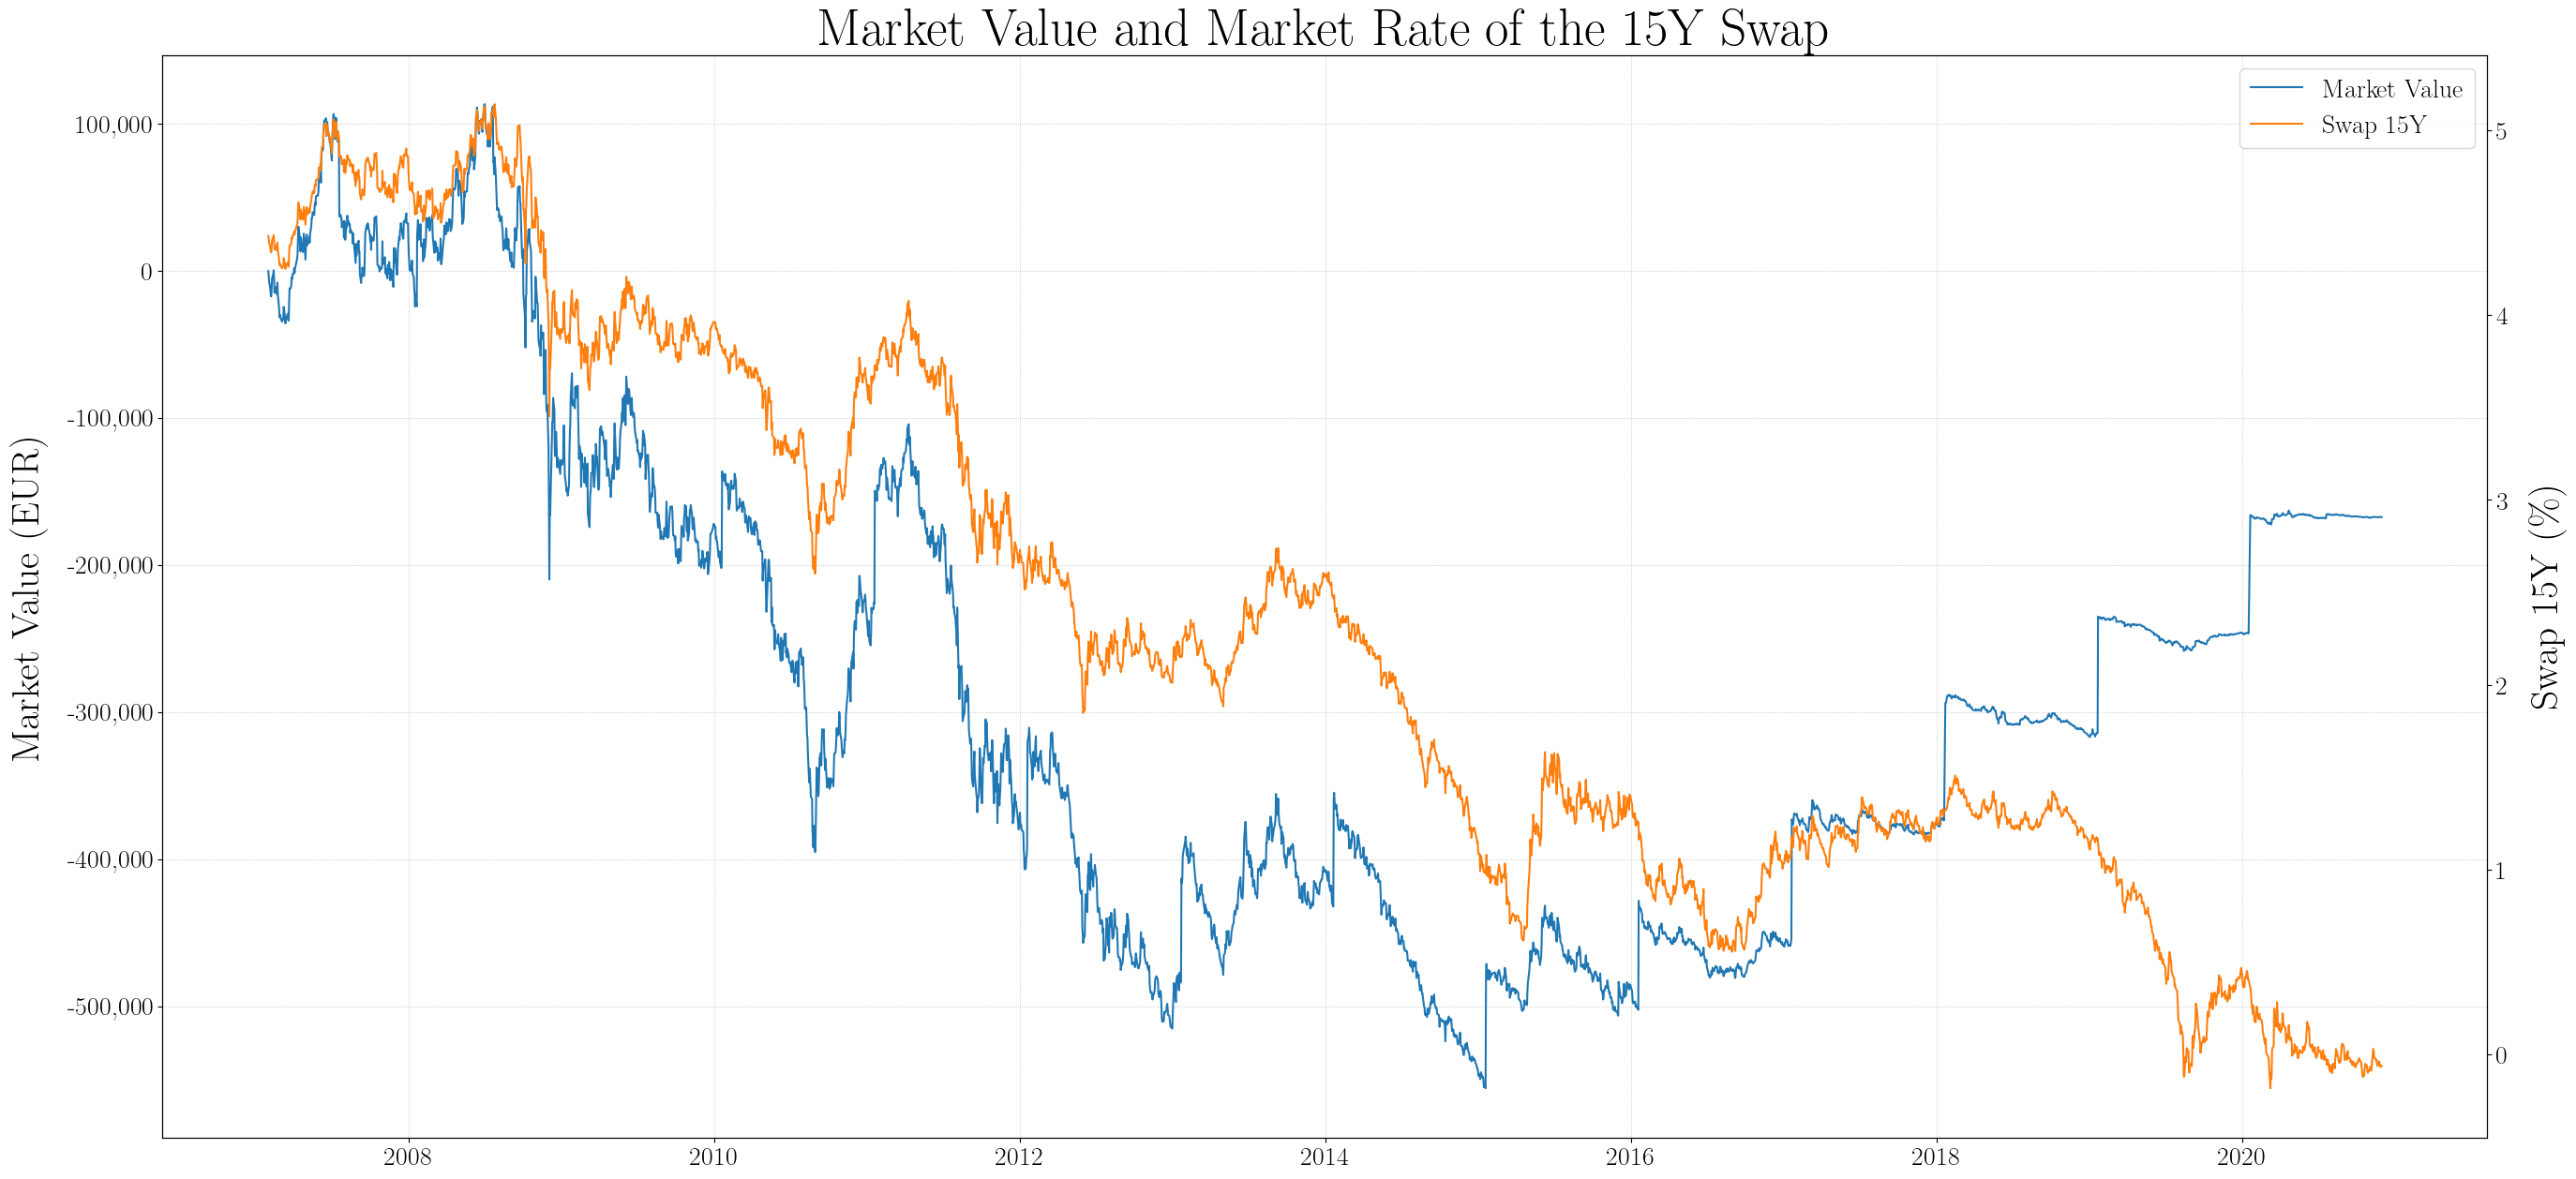

In [16]:
fig, ax = plt.subplots(figsize = (32, 15))
plt.title('Market Value and Market Rate of the 15Y Swap', fontsize = 40)

ax.plot(dates, mv, c = 'C0', label = 'Market Value')
ax.set_ylabel('Market Value (EUR)', fontsize = 30, labelpad = 15)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.grid(True, linestyle = ':', linewidth = 0.5)

ax2 = ax.twinx()
ax2.plot(dates, rate, c = 'C1', label = r'Swap 15Y')
ax2.set_ylabel('Swap 15Y (\%)', fontsize = 30, labelpad = 15)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper right')

plt.show()

##### Since starting from 2015 the market interest rates environment has become negative, the floating leg started to pay the company, bringing in this way an increasing value of the swap. Indeed, as shown in the plot, we can see peaks starting from 2015 that coincide with the semi-annual payments.

##### A company that enters in a swap contract pays a variable rate based on a benchmark interest rate (in this case the Euribor 6M) and receives a fixed rate. When interest rates fall, the variable rate paid on the floating leg decreases, which can increase the value of the swap. In a negative interest rate environment, the variable rate paid on the floating leg could be negative, meaning that the counterparty is effectively paying the company. This can lead to an increase in the market value of the swap and a divergence between the value and the market rate.

### g. Show a table for each of the swap legs with the future cashflows considering that today is the 18th of December 2020

In [17]:
crv = SwapCurve(date(2020, 12, 18))
swap.updateCurve(crv)

display(swap.floatingLeg.leg[swap.floatingLeg.leg.end > date(2020, 12, 18)].style.format({'notional': '{:,.2f}', 'rate': '{:.3%}', 'cf': '{:,.2f}'}))
display(swap.fixedLeg.leg[swap.fixedLeg.leg.end > date(2020, 12, 18)].style.format({'notional': '{:,.2f}', 'rate': '{:.3%}', 'cf': '{:,.2f}'}))

,start,end,notional,dcf,rate,df,cf
27,2020-07-20,2021-01-19,"1,748,653.15",0.508333,-0.351%,1.000463,"-3,120.03"
28,2021-01-19,2021-07-19,"1,748,653.15",0.502778,-0.516%,1.003063,"-4,532.62"
29,2021-07-19,2022-01-19,"1,748,653.15",0.511111,-0.515%,1.005711,"-4,603.42"


,start,end,notional,dcf,rate,df,cf
13,2020-01-20,2021-01-19,"1,748,653.15",1,4.422%,1.000463,"77,330.67"
14,2021-01-19,2022-01-19,"1,748,653.15",1,4.422%,1.005711,"77,330.67"


## 3. An Investment bank offered the following alternative products for the hedge:
### Alt. 1 - Company pays fixed rate X% annual 30/360 vs Euribor 6M but the bank has the right to cancel the swap after 10 years
### Alt. 2 - Company pays fixed rate X% annual 30/360 vs Euribor 6M, and sells a cap @ 6% 
### Alt. 3 - Company receives Euribor 6M and pays Euribor 6M capped @ 6% and floored @ X%

In [18]:
swaption_vols = pd.read_csv(r'/Users/riccardogurzu/Desktop/FD project/HA_swaptionNormalVol.csv').pivot(index = 'Expiry', columns = 'Tenor', values = 'NormalVol')
tenors = sorted(swaption_vols.columns, key=lambda x: int(x.replace('Yr', '')))
expiries = sorted(swaption_vols.index, key=lambda x: int(x.replace('Yr', '')) if 'Yr' in x else int(x.replace('Mo', ''))/12)
swaption_vols = swaption_vols.loc[expiries, tenors]
swaption_vols

Tenor,1Yr,2Yr,3Yr,4Yr,5Yr,7Yr,10Yr,12Yr,15Yr,20Yr,25Yr,30Yr
Expiry,,,,,,,,,,,,
1Mo,294.95,527.52,602.83,539.00,542.30,620.62,642.78,726.85,853.35,402.67,374.43,370.41
3Mo,296.68,525.47,526.55,598.62,538.65,590.22,753.58,775.66,807.94,400.97,369.76,366.58
6Mo,298.57,579.07,520.99,522.69,591.27,540.24,605.31,622.70,647.92,398.23,362.22,360.26
9Mo,296.64,502.72,540.79,515.57,550.61,535.85,532.02,527.06,518.27,384.70,354.65,353.79
1Yr,293.30,428.53,556.38,507.86,512.19,530.87,461.73,434.16,389.77,371.40,347.13,347.36
2Yr,286.11,392.33,415.12,521.62,489.08,545.65,456.85,428.13,379.32,331.13,321.85,325.04
3Yr,281.52,396.74,386.75,413.24,499.78,476.70,365.05,352.04,330.05,304.52,302.81,307.63
4Yr,278.29,335.96,395.08,394.27,435.82,521.51,357.36,334.59,295.82,285.32,287.86,293.64
5Yr,276.75,305.96,332.98,423.17,478.78,348.50,304.02,292.72,274.02,271.01,276.20,282.50


In [19]:
cap_NormVols = pd.read_csv(r'/Users/riccardogurzu/Desktop/FD project/HA_capNormalVol.csv').pivot(index = 'Strike', columns = 'Tenor', values = 'NormalVol')
cap_NormVols.index = (cap_NormVols.index.str.replace('%','').astype(float))/100
tenors = sorted(cap_NormVols.columns, key=lambda x: int(x.replace('Yr', '')))
cap_vols = cap_NormVols.loc[cap_NormVols.index, tenors]
cap_NormVols

Tenor,10Yr,12Yr,15Yr,1Yr,20Yr,25Yr,2Yr,30Yr,3Yr,4Yr,5Yr,6Yr,7Yr,8Yr,9Yr
Strike,,,,,,,,,,,,,,,
-0.010,103.68,98.79,94.17,284.76,88.49,82.27,190.45,74.57,158.78,140.91,129.31,121.03,115.11,110.60,106.87
0.000,84.11,80.37,76.83,229.50,72.26,67.04,153.05,60.53,127.60,113.27,104.03,97.49,92.88,89.42,86.56
0.010,91.57,91.44,91.04,174.68,89.59,87.50,133.39,84.69,105.37,93.92,91.83,90.97,90.68,90.59,91.62
0.015,94.95,95.10,95.00,147.73,93.97,92.32,119.77,90.03,96.90,92.89,92.95,93.07,93.29,93.51,94.84
0.020,96.60,96.76,96.79,119.09,96.09,94.78,107.47,92.88,95.21,94.99,94.89,94.88,95.02,95.20,96.48
0.025,98.86,99.04,99.16,106.91,98.64,97.54,106.07,95.90,97.33,97.14,97.05,97.06,97.20,97.39,98.71
0.030,100.86,101.11,101.25,105.70,100.85,99.90,106.12,98.45,99.33,99.15,99.07,99.09,99.23,99.41,100.72
0.035,102.76,102.98,103.16,106.44,102.86,102.01,106.90,100.70,101.23,101.05,100.98,101.00,101.13,101.32,102.61
0.040,104.61,104.84,105.05,107.52,104.80,104.03,107.93,102.82,103.01,102.84,102.77,102.79,102.93,103.12,104.45


### a. Describe the details of the derivative that is being offered and determine the X in each case so that the derivative is at fair value.

In [20]:
crv = SwapCurve(today)
swap.updateCurve(crv)
fixedRate = swap.fairRate()
swap.updateFixedRate(fixedRate)

In [21]:
def makeSchedule(start, end, freq = 6):
    schedule = []
    current_date = start
    while current_date <= end:
        schedule.append(current_date)
        current_date += relativedelta(months = freq) 
    return schedule

#### Alt. 1 - Company pays fixed rate X% annual 30/360 vs Euribor 6M but the bank has the right to cancel the swap after 10 years
##### Company gives the bank the right to cancel the swap after 10y and receives a premium. The bank will cancel the swap if in 10 years’ time it expects to receive a higher interest rate than the fixed 6% annual for the remaining life of the swap (in present values). There is an intrinsic value and an option value. The intrinsic value is the difference between the value of the 2 swaps legs in the 2 periods timeframe, first 10 years and after. Alt (1) is a swaption, also known as a swap option, and refers to an option to enter into an interest rate swap or some other type of swap. A cancellable swap is a swap with a provision that can cancel the swap at predefined dates. Cancellable swap can be viewed as a vanilla swap embedded with a Bermudan swaption. The price of a cancellable swap price is given by that of the underlying swap plus that of a Bermudan swaption that reverses the payment flows. In exchange for an options premium, the buyer gains the right but not the obligation to enter into a specified swap agreement with the issuer on a specified future date. A type of swap where one party or both parties to the swap has (or have) the right but not the obligation to terminate the swap on a specific date (or a number of specific dates) before maturity. This swap comes in two different types: callable swap and puttable swap. Advantage of the cancellable swap include the following: it subjects its holder to no penalties on cancellation and requires no upfront premium payment. The fixed rate in this swap is determined by the number of rights to cancel the swap, the time to exercise the first right to cancel and the interest rate volatility (positive correlation with these three factors).This swap is also referred to as a terminable swap. Swaptions come in two main types: a payer swaption and a receiver swaption. In a payer swaption, the purchaser has the right but not the obligation to enter into a swap contract where they become the fixed-rate payer and the floating-rate receiver. A receiver swaption is the opposite i.e. the purchaser has the option to enter into a swap contract where they will receive the fixed rate and pay the floating rate.

In [22]:
expiry = '10Yr'
tenor = '5Yr'
normalVolS = swaption_vols.loc[expiry, tenor]/10000
normalVolS

0.023648

In [23]:
swaption_start = start + relativedelta(years = 10)
dfs = list(swap.fixedLeg.leg[swap.fixedLeg.leg.start >= swaption_start].df)
swaptionSwapRate = ([dfs[0] - dfs[-1]]/np.sum(dfs[1:]))[0]
print(f"ATM Swap Rate: {swaptionSwapRate:.4%}")

ATM Swap Rate: 4.6146%


In [24]:
A = sum(dfs[1:])
T = 5

swaption = A*(normalVolS*np.sqrt(T)*norm.pdf(0))
swaptionPrice = notional*swaption

print(f"Swaption Price: {swaption:.3%}")
print(f"Swaption Price for a {notional:,.2f} notional: {swaptionPrice:,.2f}")

Swaption Price: 4.738%
Swaption Price for a 1,748,653.15 notional: 82,851.86


In [33]:
def alt1(rate):
    floatNPV = (swap.floatingLeg.leg.cf*swap.floatingLeg.leg.df).sum()
    fixed = swap.fixedLeg.leg.copy()
    fixNPV = (((fixed.notional*fixed.dcf*rate) + (swaptionPrice/len(fixed)))*fixed.df).sum()
    return fixNPV - floatNPV

result = root(alt1, 0)
fixedRate_alt1 = result.x[0]
print(f"Company pays fixed rate {fixedRate_alt1:.3%}")

Company pays fixed rate 4.056%


#### Alt. 2 - Company pays fixed rate X% annual 30/360 vs Euribor 6M, and sells a cap @ 6%
##### Company receives premium by selling a cap and pays the difference between Euribor 6 months and 6% if it’s positive. An interest rate cap is a financial contract between two parties that provides an interest rate ceiling or cap on the floating rate payments. The buyer receives payments at the end of each period when the interest rate exceeds the strike. The payment frequency could be monthly, quarterly, or semi-annually. Cap holders (the bank) get a payment when the underlying interest rate exceeds a specified strike rate. With the strike at 6.0%, the bank (cap buyer) would get paid if Euribor 6 months rose above 6.0%; otherwise, he would receive nothing if Euribor 6 months fell below it. An interest rate cap actually consists of a series of European call options (caplets) on interest rates. 

In [26]:
tenor = '15Yr'
strike_cap = 0.06
normalVol = cap_NormVols.loc[strike_cap, tenor]/10000

In [27]:
dates = makeSchedule(start, maturity)

Cap = pd.DataFrame({
    'start': dates[:-1],
    'end': dates[1:],
    'notional': notional,
    'strike': strike_cap
})

Cap['dcf'] = Cap.apply(lambda row: (row.end - row.start).days/360, axis=1)
Cap['df'] = Cap.end.apply(crv.getDF)
Cap['fwd'] = Cap.apply(lambda row: crv.fwd(row.start, row.end), axis=1)
Cap['t'] = Cap.start.apply(lambda x: (x - today).days/365)
Cap['d'] = (Cap.fwd - strike_cap)/(normalVol*np.sqrt(Cap.t))
Cap['caplet'] = notional * Cap.dcf * Cap.df * ((Cap.fwd - strike_cap)*norm.cdf(Cap.d) + normalVol*np.sqrt(Cap.t)*norm.pdf(Cap.d))

capPrice = Cap.caplet.sum()/notional
print(f"Calculated price of 15Y cap is {capPrice:.3%}")
print(f"Calculated price of 15Y cap is {Cap.caplet.sum():,.2f}")

Cap.style.format("{:,.2f}", subset = ['caplet', 'notional']).format("{:.3%}", subset = ['fwd', 'strike'])

Calculated price of 15Y cap is 5.183%
Calculated price of 15Y cap is 90,628.01


,start,end,notional,strike,dcf,df,fwd,t,d,caplet
0,2007-01-19,2007-07-19,"1,748,653.15",6.000%,0.502778,0.980406,3.889%,0.010959,-18.026649,0.00
1,2007-07-19,2008-01-19,"1,748,653.15",6.000%,0.511111,0.960018,4.155%,0.506849,-2.316834,23.81
2,2008-01-19,2008-07-19,"1,748,653.15",6.000%,0.505556,0.940392,4.128%,1.010959,-1.664403,186.38
3,2008-07-19,2009-01-19,"1,748,653.15",6.000%,0.511111,0.921134,4.090%,1.509589,-1.389541,424.50
4,2009-01-19,2009-07-19,"1,748,653.15",6.000%,0.502778,0.902799,4.039%,2.013699,-1.235240,657.19
5,2009-07-19,2010-01-19,"1,748,653.15",6.000%,0.511111,0.884175,4.121%,2.509589,-1.060442,"1,038.39"
6,2010-01-19,2010-07-19,"1,748,653.15",6.000%,0.502778,0.866554,4.044%,3.013699,-1.007116,"1,215.89"
7,2010-07-19,2011-01-19,"1,748,653.15",6.000%,0.511111,0.848653,4.127%,3.509589,-0.893895,"1,614.12"
8,2011-01-19,2011-07-19,"1,748,653.15",6.000%,0.502778,0.831588,4.082%,4.013699,-0.856136,"1,781.89"
9,2011-07-19,2012-01-19,"1,748,653.15",6.000%,0.511111,0.814250,4.166%,4.509589,-0.772086,"2,182.03"


In [28]:
floatNPV = (swap.floatingLeg.leg.cf*swap.floatingLeg.leg.df).sum()
capNPV = Cap.caplet.sum()
totNPV = floatNPV - capNPV
fixed = swap.fixedLeg.leg.copy()
fixedRate_alt2 = totNPV/(fixed.notional*fixed.dcf*fixed.df).sum()
print(f"Company pays fixed rate {fixedRate_alt2:.3%}")

Company pays fixed rate 3.896%


#### Alt. 3 - Company receives Euribor 6M and pays Euribor 6M capped @ 6% and floored @ X%
##### An interest rate floor is a financial contract between two parties that provides an interest rate floor on the floating rate payments. The buyer receives payments at the end of each period when the interest rate falls below the strike. The payment frequency could be monthly, quarterly, or semi-annually. The exercise is done automatically that is different from any other types of options. The buyer needs to pay an up-front premium to the seller. The floor holders get a payment when the underlying interest rate falls below a specified strike rate. With a strike at X%, the bank (floor buyer) would get paid if Euribor 6 months fell below X%; otherwise, he would receive nothing if Euribor rose above it. An interest rate floor actually consists of a series of European put options (floorlets) on interest rates. 

In [34]:
f = interp1d(cap_NormVols.index, cap_NormVols['15Yr']/10000, kind = 'linear', fill_value = "extrapolate")

Floor = pd.DataFrame({
    'start': dates[:-1],
    'end': dates[1:],
    'notional': notional,
    'strike': 0
})

Floor['dcf'] = Floor.apply(lambda row: (row.end - row.start).days/360, axis=1)
Floor['df'] = Floor.end.apply(crv.getDF)
Floor['fwd'] = Floor.apply(lambda row: crv.fwd(row.start, row.end), axis=1)
Floor['t'] = Floor.start.apply(lambda x: (x - today).days/365)
Floor['d'] = (Floor.fwd - 0)/(f(0)*np.sqrt(Floor.t))
Floor['floorlet'] = notional*Floor.dcf*Floor.df*((0 - Floor.fwd)*norm.cdf(-Floor.d) + f(0)*np.sqrt(Floor.t)*norm.pdf(Floor.d))

In [32]:
def floor_strike(strike):
    Floor['d'] = (Floor.fwd - strike)/(f(strike)*np.sqrt(Floor.t))
    Floor['floorlet'] = notional*Floor.dcf*Floor.df*((strike - Floor.fwd)*norm.cdf(-Floor.d) + f(strike)*np.sqrt(Floor.t)*norm.pdf(Floor.d))
    floorNPV = Floor.floorlet.sum() 
    return floorNPV - capNPV

result = root(floor_strike, 0)
strike_floor = result.x[0]
print(f"The value of floor strike that makes pay leg fair is: {strike_floor:.3%}")

The value of floor strike that makes pay leg fair is: 2.986%


### b. Which one would you choose (There are no wrong choices)? Please justify your answer

##### We would choose the plain vanilla IRS or Alt. 3.

##### The interest rate swap allows the company to lock in the cost of the loan to the annual fixed interest rate for the full life of the loan of 15 years.The IRS gives the company a full certainty of the cost of financing of the investment to be made, getting rid of interest rate risk, i.e., the Euribor interest rate movements, namely its increases, through the life of the financing. The alternatives presented do not offer a perfect hedged to borrowing costs at variable interest rates. 

##### Alt (1) reduces the cost of the IRS (lower fixed interest rate to be paid) to the company by selling an option to the bank to cancel the swap after 10 years. The company gets a lower fixed interest rate but will be exposed to interest rate risk after year 10 if the bank decides to cancel the bank. That occurs if there is an increase in forward/futures Euribor 6 months at 10 years’ time compared to corresponding today’s levels for the period between 2017 and 2022.

##### Alt (2) also reduces the cost of the of the IRS (lower fixed rate to be paid) to the company by selling a cap option to the bank at 6%. The company gets again a lower fixed interest rate but will be exposed to the interest rate risk of Euribor 6 months increasing above 6% at any semi-annual period through the life of the loan. Whenever that happens in each of the fixing coupon period, the company will pay the difference between the prevailing Euribor 6 month above 6% and the 6% cap to the bank. 

##### Alt (3) is a more similar hedge to the IRS. The company keeps paying Euribor 6 months in the loan, protects the risk of an increase of interest rates above 6% by buying the cap and paying the corresponding premium, and reduces the costs of the borrowing and the cap option by selling a floor at 3%, by letting out the benefit of  Euribor 6 months going below 3%.

##### We think the plain vanilla IRS and Alt (3) are the best options in terms of interest rate risk management. The IRS provides a perfect hedge and locks the cost of financing the investment. The certainty cost to the investment project is an advantage. Alt (3), an interest rate collar, exposes the company to the risk of paying interest rates up to 6% and not benefiting from interest rates going lower than 3%. The Alt (3) gives some certainty that the cost of financing will be Euribor 6 months, within the interval of 3% to 6%, plus the net cost of the buying the cap and selling the floor. 
    
##### Caps are frequently purchased by issuers of floating rate debt who wish to protect themselves from the increased financing costs that would result from a rise in interest rates. Floors are frequently purchased by purchasers of floating rate debt who wish to protect themselves from the loss of income that would result from a decline in interest rates. Investors use caps and floors to hedge against the risk associated with floating interest rate. Cap holders will benefit from any risk in interest rates above the strike, while floor holders will benefit from any risk in interest rates above the strike.An interest rate swap with floor/cap is an upgrade of the standard interest rate swap limiting the variable interest rate which is paid in the interest rate swap transaction.Interest rate caps are one of the most efficient ways to hedge against an increase in a floating interest rate. Caps offer many advantages over other types of interest rate hedges, like swaps, such as: a defined cost, paid when the cap is purchased; no prepayment penalty or termination cost; cap owner retains exposure to the floating rate, should it move lower; greatly reduced transaction cost; totally customizable, to achieve the perfect balance of protection and cost; can be bid out between multiple bank providers to achieve to lowest available cost; can be transferred to other floating rate debt.

### c. Plot on the same graph the rate that the company would pay in each of the 4 alternatives (simple swap, and the 3 additional alternatives) for each value of Euribor 6M fixing between 0 and 10% (derivative rate on y axis and Euribor fixing on x axis)

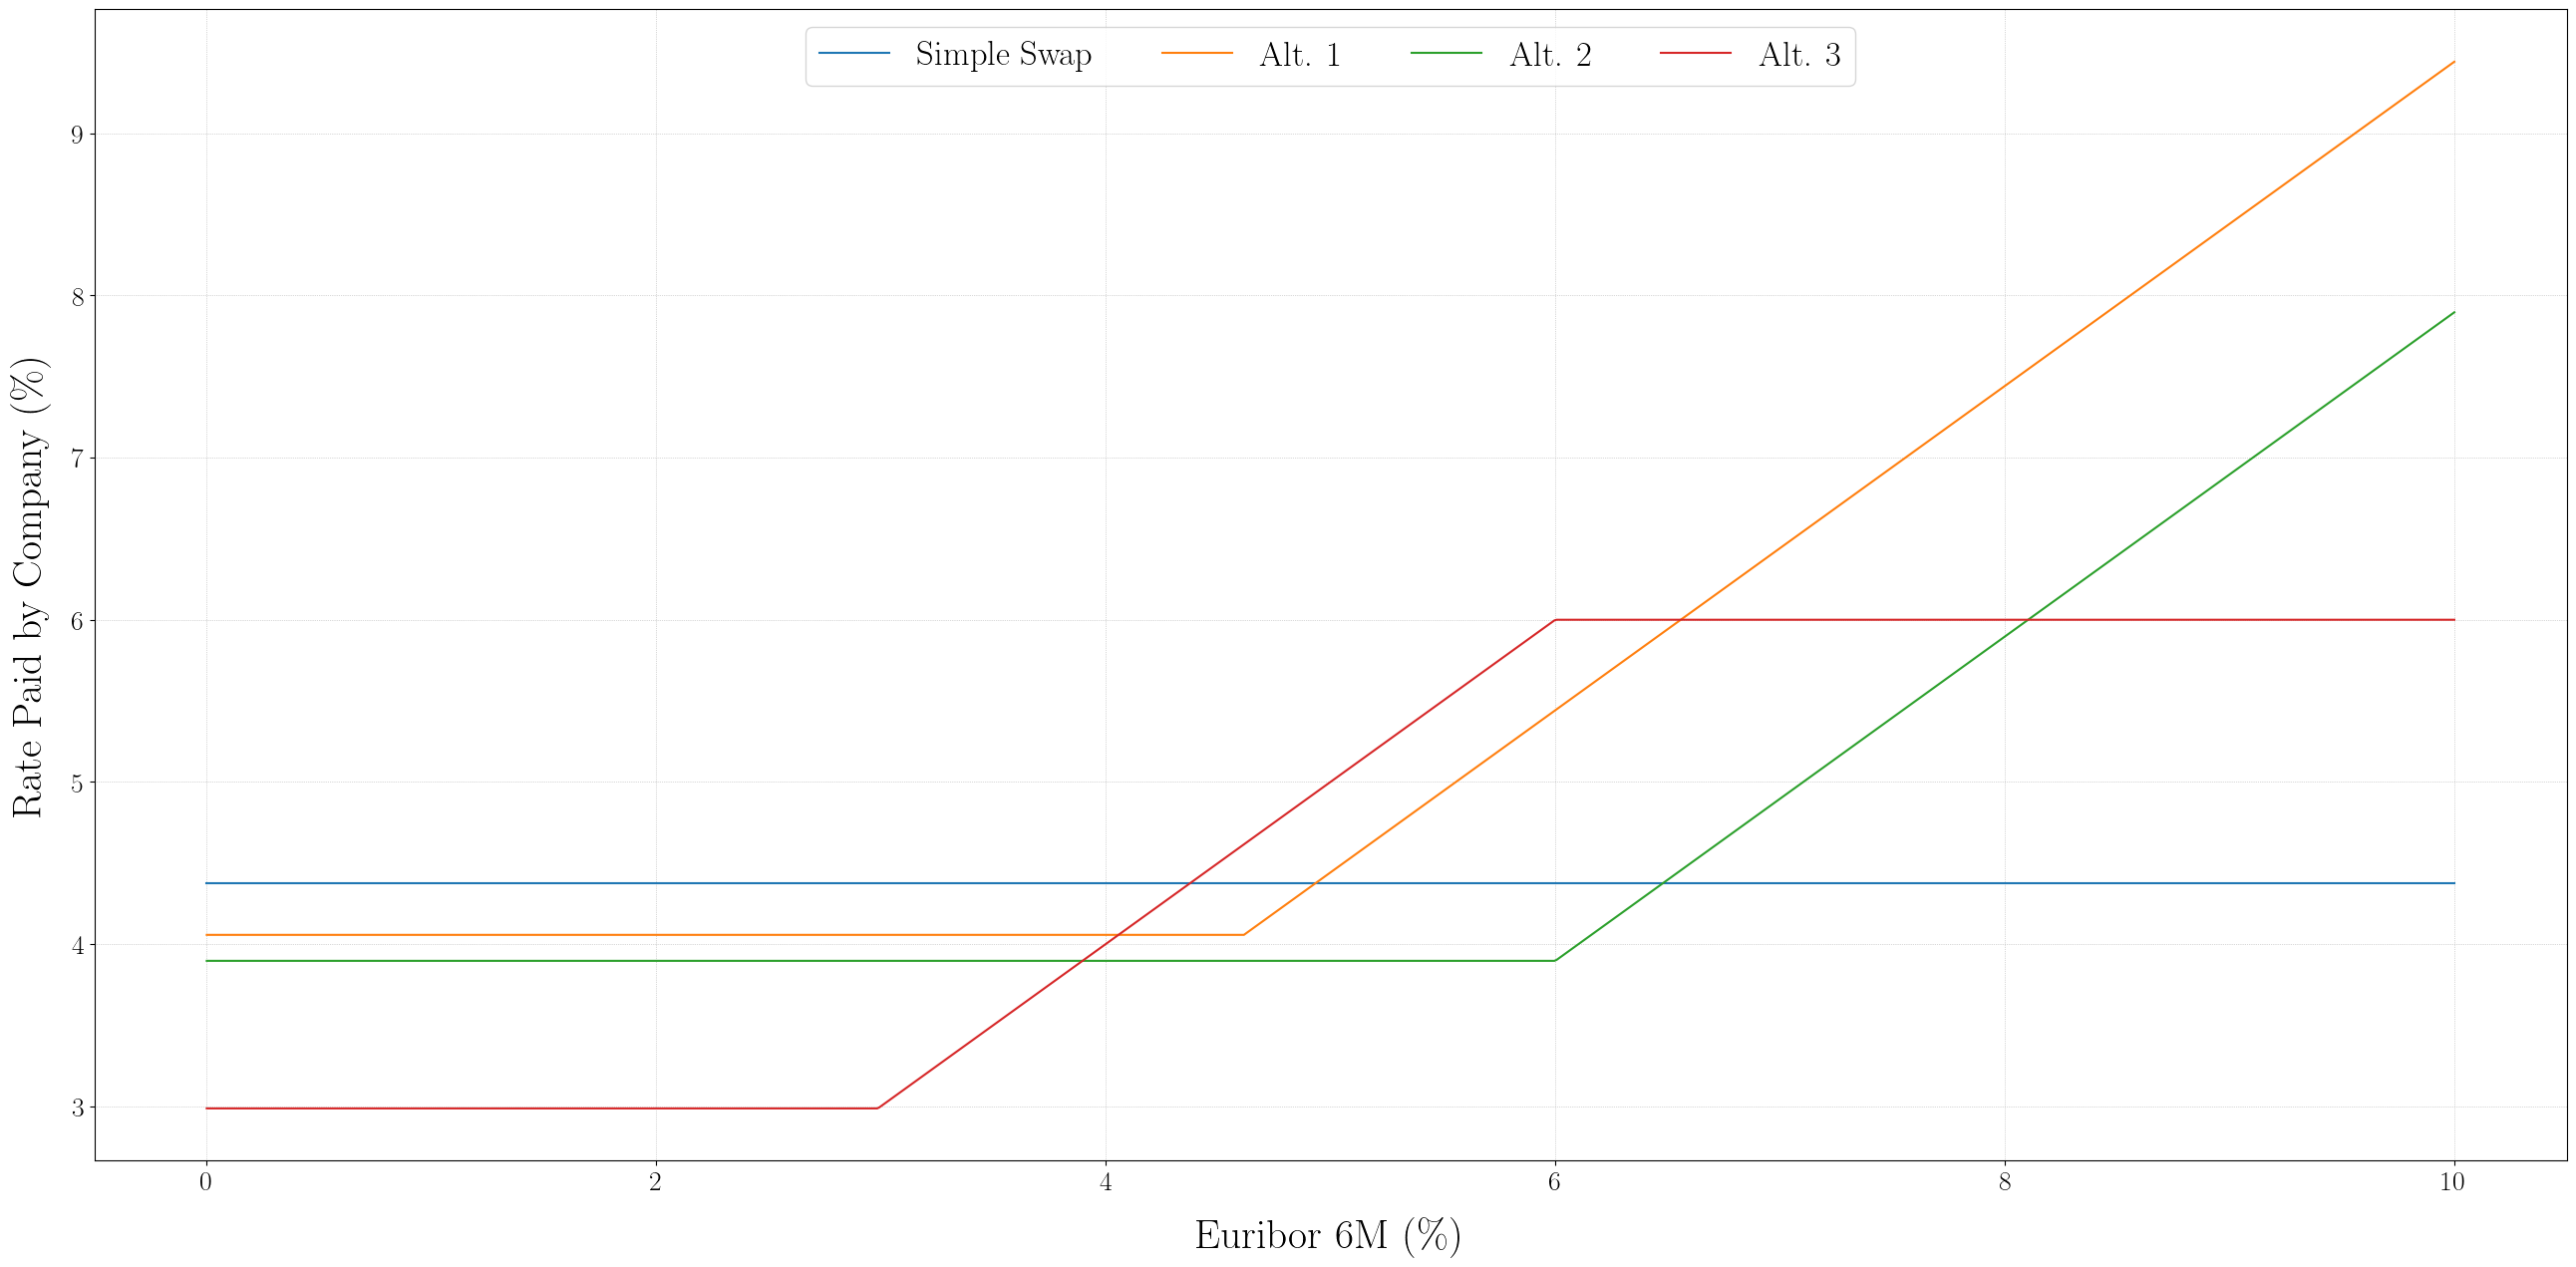

In [31]:
X = np.linspace(0, 10, num = 1000)

plt.figure(figsize = (32, 15))

plt.plot(X, [fixedRate*100] * len(X), label = 'Simple Swap')
plt.plot(X, [fixedRate_alt1*100 + max(x - swaptionSwapRate*100, 0) for x in X], label = 'Alt. 1')
plt.plot(X, [fixedRate_alt2*100 + max(x - strike_cap*100, 0) for x in X], label = 'Alt. 2')
plt.plot(X, [x - max(x - strike_cap*100, 0) + max(strike_floor*100 - x, 0) for x in X], label = 'Alt. 3')
plt.xlabel('Euribor 6M (\%)', fontsize = 30, labelpad = 15)
plt.ylabel('Rate Paid by Company (\%)', fontsize = 30, labelpad = 15)
plt.legend(loc = 'upper center', bbox_to_anchor = (.5, 1), ncol = 4, fontsize = 25)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.show()